In [1]:
import json
import numpy as np
import cv2
from scipy.optimize import minimize
from nvbts.calib import Cam2SensorCalib
from nvbts.utils import dome_3d

# from nvbts.objective import Cam2Sensor
calibration_file = '/home/hussain/calib_ws/src/aric-camera-calibration/calibration_data/long sensor/calibration_results.json'  # Change this to your calibration fil
calibrator = Cam2SensorCalib(calibration_file)

# Load the 3D markers
markers_3d = dome_3d()
calibrator.set_3d_markers(markers_3d)

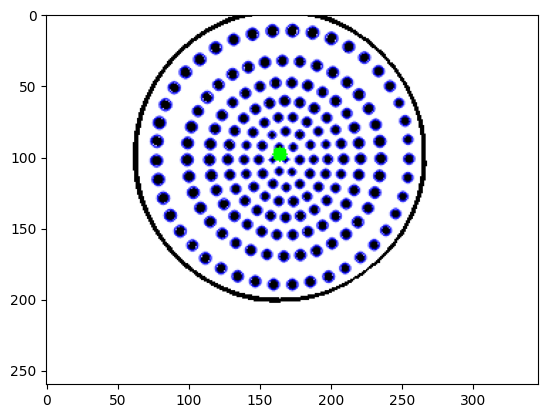

In [7]:
import matplotlib.pyplot as plt
from nvbts.markers import MarkerDetector

# Load the image
image = cv2.imread('/home/hussain/me/projects/nvbts/image.png')
md = MarkerDetector('nvbts/markers/blob.json', calibration_file)

# Detect the markers

img_with_markers, markers = md.apply(image, draw_keypoints=True)

# Draw the markers
plt.imshow(img_with_markers)

In [11]:
from nvbts.utils import sort_markers_k_means

markers_x, markers_y = markers[:, 0], markers[:, 1]

# Sort the markers
sorted_x, sorted_y , layer = sort_markers_k_means(markers_x, markers_y)




markers_exp = np.stack((sorted_x, sorted_y), axis=1)

calibrator.set_2d_markers(markers_exp)

/home/hussain/miniconda3/envs/tmx/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hussain/miniconda3/envs/tmx/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Reprojection error: 2.851320185882265
Euler angles: [3.05640364 0.03421519 3.13706568]
Translation: [ 0.00393783 -0.00041309 -0.04893093]


(array([3.05640364, 0.03421519, 3.13706568]),
 array([ 0.00393783, -0.00041309, -0.04893093]))

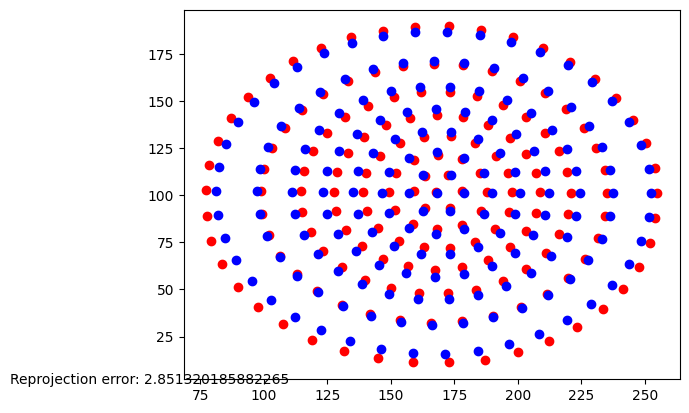

In [ ]:
calibrator.calibrate()

In [ ]:
success, rotation_vector, translation_vector = cv2.solvePnP(markers_T_sensor, markers_exp, camera_matrix, dist_coeffs)

print(rotation_vector, '\n', translation_vector)
# project 3D points to image plane
imgpts, jac = cv2.projectPoints(markers_T_sensor, rotation_vector, translation_vector, camera_matrix, dist_coeffs)

imgpts = imgpts.reshape(cam2sensor.num_markers,2)
plt.scatter(*imgpts.T, c='r')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.scatter(*markers_exp.reshape(cam2sensor.num_markers,2).T, c='k')#, alpha=np.arange(1, 64) / 128 + 1/2)


NameError: name 'markers_T_sensor' is not defined

In [ ]:

rotation_vector_ = np.array([[-0.00470576],
 [-3.10506219],
 [-0]] )

imgpts, jac = cv2.projectPoints(markers_T_sensor, rotation_vector, translation_vector, camera_matrix, dist_coeffs)

imgpts = imgpts.reshape(cam2sensor.num_markers,2)
plt.scatter(*imgpts.T, c='r')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.scatter(*markers_exp.reshape(cam2sensor.num_markers,2).T, c='k')#, alpha=np.arange(1, 64) / 128 + 1/2)


NameError: name 'markers_T_sensor' is not defined

In [ ]:
R.from_matrix(R.from_euler("xyz", rotation_vector.T).as_matrix()[0].T).as_euler("xyz")

AttributeError: 'list' object has no attribute 'from_matrix'

In [ ]:
from scipy.spatial.transform import Rotation as R

rot_mat = R.from_euler("xyz", rotation_vector.T).as_matrix()
transform_mat = np.eye(4)

transform_mat[:3, :3] = rot_mat
transform_mat[:3, 3] = translation_vector.T

transform_mat

array([[-0.98970294,  0.13865978, -0.03551829,  0.00224231],
       [ 0.1383987 ,  0.99032891,  0.00971836,  0.00471796],
       [ 0.03652234,  0.00470261, -0.99932177, -0.04879708],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
transform_mat.T

array([[-0.98970294,  0.1383987 ,  0.03652234,  0.        ],
       [ 0.13865978,  0.99032891,  0.00470261,  0.        ],
       [-0.03551829,  0.00971836, -0.99932177,  0.        ],
       [ 0.00224231,  0.00471796, -0.04879708,  1.        ]])